# 메타 포트폴리오 백테스팅 시스템

main.py 실행 결과로 생성된 meta_analysis 경로의 메타 포트폴리오 CSV 파일들을 기반으로 백테스팅을 수행합니다.


In [42]:
# 메타 포트폴리오 백테스팅 시스템
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

class MetaPortfolioBacktester:
    """메타 포트폴리오 백테스팅 클래스"""
    
    def __init__(self, 
                 meta_results_dir="results/meta_analysis",
                 ohlcv_path="data/nasdaq100_ohlcv.csv",
                 benchmark_cache_path="data/benchmark_data.csv",
                 transaction_cost=0.0001):  # 0.01% 거래비용
        
        self.meta_results_dir = meta_results_dir
        self.ohlcv_path = ohlcv_path
        self.benchmark_cache_path = benchmark_cache_path
        self.transaction_cost = transaction_cost
        
        # 벤치마크 티커들 정의
        self.benchmarks = {
            'QQQ': {'name': 'NASDAQ 100 ETF', 'color': 'black'},
            'SPY': {'name': 'S&P 500 ETF', 'color': 'gray'}
        }
        
        # 데이터 로드
        self.load_data()
        
        # 백테스팅 결과 저장용
        self.backtest_results = {}
        
    def download_and_cache_benchmark_data(self, start_date='2020-01-01', end_date=None):
        """Yahoo Finance에서 벤치마크 데이터를 다운로드하고 캐시에 저장"""
        
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        print("벤치마크 데이터 다운로드 및 캐싱 중...")
        
        all_benchmark_data = []
        
        for ticker in self.benchmarks.keys():
            try:
                print(f"  - {ticker} ({self.benchmarks[ticker]['name']}) 다운로드 중...")
                
                data = yf.download(ticker, start=start_date, end=end_date, progress=False)
                
                if data.empty:
                    print(f"    경고: {ticker} 데이터를 가져올 수 없습니다.")
                    continue
                    
                data = data.reset_index()
                data['ticker'] = ticker
                data['date'] = pd.to_datetime(data['Date'])
                data['price'] = data['Adj Close'] if 'Adj Close' in data.columns else data['Close']
                
                clean_data = data[['ticker', 'date', 'price']].copy()
                all_benchmark_data.append(clean_data)
                
                print(f"    {ticker}: {len(clean_data)}개 데이터 포인트 다운로드 완료")
                
            except Exception as e:
                print(f"    오류: {ticker} 다운로드 실패 - {e}")
                continue
        
        if all_benchmark_data:
            combined_data = pd.concat(all_benchmark_data, ignore_index=True)
            os.makedirs(os.path.dirname(self.benchmark_cache_path), exist_ok=True)
            combined_data.to_csv(self.benchmark_cache_path, index=False)
            print(f"벤치마크 데이터가 {self.benchmark_cache_path}에 저장되었습니다.")
            return combined_data
        else:
            print("다운로드된 벤치마크 데이터가 없습니다.")
            return None
            
    def load_benchmark_data(self, force_download=False):
        """캐시된 벤치마크 데이터 로드 또는 다운로드"""
        
        if force_download or not os.path.exists(self.benchmark_cache_path):
            return self.download_and_cache_benchmark_data()
        
        try:
            print("캐시된 벤치마크 데이터를 로드합니다...")
            benchmark_data = pd.read_csv(self.benchmark_cache_path)
            benchmark_data['date'] = pd.to_datetime(benchmark_data['date'])
            
            # 데이터가 최신인지 확인
            latest_date = benchmark_data['date'].max()
            if (datetime.now() - latest_date).days > 7:
                print("벤치마크 데이터가 오래되었습니다. 업데이트 중...")
                return self.download_and_cache_benchmark_data()
            
            return benchmark_data
            
        except Exception as e:
            print(f"캐시 로드 실패: {e}")
            return self.download_and_cache_benchmark_data()
        
    def load_data(self):
        """필요한 데이터들을 로드"""
        print("데이터 로딩 중...")
        
        # OHLCV 데이터 로드
        print("  - OHLCV 데이터 로딩...")
        self.ohlcv_df = pd.read_csv(self.ohlcv_path)
        self.ohlcv_df['EVAL_D'] = pd.to_datetime(self.ohlcv_df['EVAL_D'])
        
        # 메타 포트폴리오 파일들 로드
        print("  - 메타 포트폴리오 결과 파일들 로딩...")
        self.load_meta_portfolio_files()
        
        # 벤치마크 데이터 로드
        print("  - 벤치마크 데이터 로딩...")
        self.benchmark_df = self.load_benchmark_data()
        
        print("데이터 로딩 완료!")
        
    def load_meta_portfolio_files(self):
        """메타 포트폴리오 CSV 파일들을 로드"""
        portfolio_files = glob.glob(f"{self.meta_results_dir}/meta_portfolio_*.csv")
        
        portfolios = []
        
        for file in sorted(portfolio_files):
            try:
                # 파일명에서 날짜 추출
                filename = os.path.basename(file)
                date_part = filename.replace('meta_portfolio_', '').replace('.csv', '')
                start_date, end_date = date_part.split('_')
                
                # CSV 파일 로드
                df = pd.read_csv(file)
                if len(df) == 0 or (len(df) == 1 and df.iloc[0].isnull().all()):
                    continue
                    
                # 빈 행 제거
                df = df.dropna(subset=['Ticker'])

                # Ticker가 중복되는 경우, 첫번째 가중치만 사용
                if df.duplicated('Ticker').any():
                    df = df.drop_duplicates(subset=['Ticker'], keep='first')

                # Weight (%) 컬럼 정규화
                if 'Weight (%)' in df.columns and sum(df['Weight (%)']) != 100:
                    df['Weight (%)'] = df['Weight (%)'] / sum(df['Weight (%)']) * 100
                
                if len(df) > 0:
                    df['analysis_start'] = pd.to_datetime(start_date)
                    df['analysis_end'] = pd.to_datetime(end_date)
                    # 메타 포트폴리오는 바로 분석 기간에 투자한다고 가정
                    df['investment_start'] = df['analysis_start']
                    df['investment_end'] = df['analysis_end']
                    
                    portfolios.append(df)
                    
            except Exception as e:
                print(f"파일 로딩 실패: {file}, 오류: {e}")
                
        if portfolios:
            self.meta_portfolios = pd.concat(portfolios, ignore_index=True)
            print(f"  - 메타 포트폴리오: {len(portfolios)}개 포트폴리오 로드됨")
        else:
            print(f"  - 메타 포트폴리오: 포트폴리오 데이터 없음")
            self.meta_portfolios = None


In [43]:
# 가격 데이터 조회 및 백테스팅 계산 메서드들 (MetaPortfolioBacktester 클래스의 일부)

def get_price_data(self, ticker, start_date, end_date):
    """특정 기간의 주가 데이터 조회"""
    ticker_data = self.ohlcv_df[
        (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
        (self.ohlcv_df['EVAL_D'] >= start_date) &
        (self.ohlcv_df['EVAL_D'] <= end_date)
    ].copy()
    
    if len(ticker_data) == 0:
        return None
        
    ticker_data['price'] = ticker_data['DIV_ADJ_CLOSE'].fillna(ticker_data['CLOSE_'])
    return ticker_data[['EVAL_D', 'price']].sort_values('EVAL_D')
    
def get_benchmark_data(self, ticker, start_date, end_date):
    """캐시된 벤치마크 데이터에서 특정 기간 조회"""
    if self.benchmark_df is None:
        return None
        
    ticker_data = self.benchmark_df[
        (self.benchmark_df['ticker'] == ticker) &
        (self.benchmark_df['date'] >= start_date) &
        (self.benchmark_df['date'] <= end_date)
    ].copy()
    
    if len(ticker_data) == 0:
        return None
        
    return ticker_data[['date', 'price']].sort_values('date')
    
def calculate_meta_portfolio_returns(self, start_date=None, end_date=None):
    """메타 포트폴리오의 수익률 계산"""
    if self.meta_portfolios is None:
        print("메타 포트폴리오 데이터가 없습니다.")
        return pd.DataFrame()
        
    portfolio_timeline = self.meta_portfolios
    
    if start_date is None:
        start_date = portfolio_timeline['investment_start'].min()
    if end_date is None:
        end_date = portfolio_timeline['investment_end'].max()
        
    print(f"\n메타 포트폴리오 백테스팅: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
    
    # 리밸런싱 날짜 찾기
    rebalance_dates = sorted(portfolio_timeline['investment_start'].unique())
    
    all_results = []
    current_portfolio_value = 1.0
    
    for i, rebalance_date in enumerate(rebalance_dates):
        period_portfolio = portfolio_timeline[
            portfolio_timeline['investment_start'] == rebalance_date
        ]
        
        period_start = period_portfolio['investment_start'].iloc[0]
        period_end = period_portfolio['investment_end'].iloc[0]
        
        print(f"  리밸런싱 {i+1}: {period_start.strftime('%Y-%m-%d')} ~ {period_end.strftime('%Y-%m-%d')}")
        
        # 해당 기간의 주가 데이터 수집
        period_data = {}
        weights = {}
        
        for _, stock in period_portfolio.iterrows():
            ticker = stock['Ticker']
            weight = float(stock['Weight (%)']) / 100.0
            weights[ticker] = weight
            
            ticker_data = self.ohlcv_df[
                (self.ohlcv_df['TICKERSYMBOL'] == ticker) &
                (self.ohlcv_df['EVAL_D'] >= period_start) &
                (self.ohlcv_df['EVAL_D'] <= period_end)
            ].copy()
            
            if len(ticker_data) == 0:
                continue
            
            close_columns = [col for col in ticker_data.columns if 'CLOSE' in col.upper()]
            if not close_columns:
                continue
            
            close_col = close_columns[0]
            period_data[ticker] = ticker_data[['EVAL_D', close_col]].copy()
            period_data[ticker].rename(columns={close_col: 'price'}, inplace=True)
        
        if not period_data:
            continue
        
        # 모든 종목의 날짜를 통합
        all_dates = set()
        for ticker_data in period_data.values():
            all_dates.update(ticker_data['EVAL_D'].tolist())
        all_dates = sorted(all_dates)
        
        # 기간 시작 시점의 가격으로 정규화
        start_prices = {}
        for ticker, ticker_data in period_data.items():
            start_price_data = ticker_data[ticker_data['EVAL_D'] == period_start]
            if len(start_price_data) > 0:
                start_prices[ticker] = start_price_data['price'].iloc[0]
            else:
                valid_data = ticker_data[ticker_data['EVAL_D'] <= period_start]
                if len(valid_data) > 0:
                    start_prices[ticker] = valid_data['price'].iloc[-1]
                else:
                    start_prices[ticker] = ticker_data['price'].iloc[0]
        
        # 각 날짜별 포트폴리오 가치 계산
        period_results = []
        
        for date in all_dates:
            portfolio_value = 0.0
            valid_stocks = 0
            
            for ticker, weight in weights.items():
                if ticker not in period_data or ticker not in start_prices:
                    continue
                
                ticker_data = period_data[ticker]
                price_data = ticker_data[ticker_data['EVAL_D'] <= date]
                
                if len(price_data) > 0:
                    current_price = price_data['price'].iloc[-1]
                    start_price = start_prices[ticker]
                    
                    stock_return = (current_price / start_price) if start_price != 0 else 1.0
                    portfolio_value += stock_return * weight
                    valid_stocks += 1
            
            if valid_stocks > 0:
                period_results.append({
                    'date': date,
                    'period_return': portfolio_value,
                    'period': i + 1
                })
        
        # 기간별 결과를 전체 포트폴리오 가치에 연결
        if period_results:
            period_start_value = current_portfolio_value
            
            for result in period_results:
                result['cumulative_value'] = period_start_value * result['period_return']
                all_results.append(result)
            
            current_portfolio_value = period_results[-1]['cumulative_value']
    
    if not all_results:
        return pd.DataFrame()
    
    # 최종 DataFrame 생성
    final_df = pd.DataFrame(all_results)
    final_df = final_df.sort_values('date').reset_index(drop=True)
    
    # 수익률 지표 계산
    # normalized_value는 첫 번째 값으로 정규화하여 1.0에서 시작
    final_df['normalized_value'] = final_df['cumulative_value'] / final_df['cumulative_value'].iloc[0]
    final_df['daily_return'] = final_df['normalized_value'].pct_change()
    final_df['cumulative_return'] = (final_df['normalized_value'] - 1) * 100
    
    result_df = final_df[['date', 'normalized_value', 'daily_return', 'cumulative_return']].copy()
    
    print(f"  최종 누적 수익률: {result_df['cumulative_return'].iloc[-1]:.2f}%")
    
    return result_df

# 이 함수들을 MetaPortfolioBacktester 클래스에 추가
MetaPortfolioBacktester.get_price_data = get_price_data
MetaPortfolioBacktester.get_benchmark_data = get_benchmark_data  
MetaPortfolioBacktester.calculate_meta_portfolio_returns = calculate_meta_portfolio_returns


In [44]:
# 벤치마크 및 성과 지표 계산 메서드들

def calculate_benchmark_returns(self, start_date, end_date, benchmark_tickers=None):
    """벤치마크 수익률 계산"""
    if benchmark_tickers is None:
        benchmark_tickers = list(self.benchmarks.keys())
        
    benchmark_results = {}
    
    for ticker in benchmark_tickers:
        benchmark_data = self.get_benchmark_data(ticker, start_date, end_date)
        
        if benchmark_data is None or len(benchmark_data) == 0:
            continue
            
        benchmark_data['normalized_value'] = benchmark_data['price'] / benchmark_data['price'].iloc[0]
        benchmark_data['daily_return'] = benchmark_data['normalized_value'].pct_change()
        benchmark_data['cumulative_return'] = (benchmark_data['normalized_value'] - 1) * 100
        
        benchmark_results[ticker] = benchmark_data
        
    return benchmark_results
    
def calculate_performance_metrics(self, returns_df):
    """성과 지표 계산"""
    if returns_df is None or len(returns_df) == 0:
        return {}
        
    daily_returns = returns_df['daily_return'].dropna()
    
    if len(daily_returns) == 0:
        return {}
        
    metrics = {}
    
    # 기본 수익률 지표
    metrics['총 수익률 (%)'] = returns_df['cumulative_return'].iloc[-1]
    metrics['연환산 수익률 (%)'] = ((returns_df['normalized_value'].iloc[-1] ** (252 / len(returns_df))) - 1) * 100
    
    # 리스크 지표
    metrics['변동성 (%)'] = daily_returns.std() * np.sqrt(252) * 100
    metrics['샤프 비율'] = (metrics['연환산 수익률 (%)'] / metrics['변동성 (%)']) if metrics['변동성 (%)'] != 0 else 0
    
    # 최대 낙폭
    running_max = returns_df['normalized_value'].expanding().max()
    drawdown = (returns_df['normalized_value'] - running_max) / running_max
    metrics['최대 낙폭 (%)'] = drawdown.min() * 100
    
    # 승률
    positive_days = (daily_returns > 0).sum()
    total_days = len(daily_returns)
    metrics['승률 (%)'] = (positive_days / total_days) * 100 if total_days > 0 else 0
    
    return metrics

def run_meta_portfolio_backtest(self, start_date=None, end_date=None, force_download_benchmarks=False):
    """메타 포트폴리오 백테스팅 실행"""
    print("=" * 80)
    print("메타 포트폴리오 백테스팅 시작")
    print("=" * 80)
    
    if force_download_benchmarks:
        self.benchmark_df = self.load_benchmark_data(force_download=True)
    
    # 메타 포트폴리오 수익률 계산
    meta_returns = self.calculate_meta_portfolio_returns(start_date, end_date)
    
    if len(meta_returns) == 0:
        print("백테스팅할 메타 포트폴리오 데이터가 없습니다!")
        return None
    
    # 전체 기간 설정
    if start_date is None:
        start_date = meta_returns['date'].min()
    if end_date is None:
        end_date = meta_returns['date'].max()
    
    # 성과 지표 계산
    meta_metrics = self.calculate_performance_metrics(meta_returns)
    
    # 벤치마크 수익률 계산
    benchmark_results = self.calculate_benchmark_returns(start_date, end_date)
    benchmark_metrics = {}
    
    for ticker, data in benchmark_results.items():
        benchmark_metrics[ticker] = self.calculate_performance_metrics(data)
    
    # 결과 저장
    self.backtest_results = {
        'meta_returns': meta_returns,
        'meta_metrics': meta_metrics,
        'benchmark_results': benchmark_results,
        'benchmark_metrics': benchmark_metrics,
        'start_date': start_date,
        'end_date': end_date
    }
    
    return self.backtest_results

# 클래스에 메서드 추가
MetaPortfolioBacktester.calculate_benchmark_returns = calculate_benchmark_returns
MetaPortfolioBacktester.calculate_performance_metrics = calculate_performance_metrics
MetaPortfolioBacktester.run_meta_portfolio_backtest = run_meta_portfolio_backtest


In [45]:
# 시각화 메서드들

def plot_meta_portfolio_performance(self, figsize=(20, 10)):
    """메타 포트폴리오 성과 차트"""
    if not self.backtest_results:
        print("백테스팅을 먼저 실행해주세요!")
        return
        
    fig, axes = plt.subplots(figsize=figsize)
    
    # 메타 포트폴리오 플롯
    meta_returns = self.backtest_results['meta_returns']
    axes.plot(meta_returns['date'], meta_returns['cumulative_return'], 
            label='Meta Portfolio', 
            linewidth=3, color='red')
    
    # 벤치마크들 플롯
    for ticker, data in self.backtest_results['benchmark_results'].items():
        if data is not None:
            benchmark_info = self.benchmarks[ticker]
            axes.plot(data['date'], data['cumulative_return'], 
                    label=benchmark_info['name'], 
                    linewidth=2, color=benchmark_info['color'], 
                    linestyle='--', alpha=0.8)
                    
    # axes.set_title('메타 포트폴리오 vs 벤치마크 누적 수익률 비교', fontsize=16, fontweight='bold')
    axes.set_ylabel('Cumulative Return (%)', fontsize=12)
    axes.set_xlabel('Date', fontsize=12)
    axes.legend(fontsize=12)
    axes.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_portfolio_weights(self, figsize=(20, 8)):
    """메타 포트폴리오 구성 비중 히스토그램 (리밸런싱별 누적 히스토그램)"""
    if self.meta_portfolios is None:
        print("메타 포트폴리오 데이터가 없습니다!")
        return

    # 리밸런싱 날짜별로 서브플롯 생성
    rebalance_dates = sorted(self.meta_portfolios['investment_start'].unique())
    fig, axes = plt.subplots(len(rebalance_dates), 1, figsize=figsize)

    # 단일 리밸런싱 날짜인 경우 axes를 리스트로 변환
    if len(rebalance_dates) == 1:
        axes = [axes]

    for i, date in enumerate(rebalance_dates):
        df = self.meta_portfolios[self.meta_portfolios['investment_start'] == date]
        df = df[['Ticker', 'Weight (%)']]
        df = df.sort_values('Weight (%)', ascending=True)  # 누적 히스토그램을 위해 오름차순 정렬

        bottom = 0
        for _, row in df.iterrows():
            # 각 종목별 누적 막대 그리기
            axes[i].bar(date, row['Weight (%)'], bottom=bottom, width=60, alpha=0.8)
            # 비중이 3% 이상인 경우만 티커 표시
            if row['Weight (%)'] > 3:
                axes[i].text(date, bottom + row['Weight (%)']/2, row['Ticker'],
                             ha='center', va='center', fontsize=8)
            bottom += row['Weight (%)']

        axes[i].set_title(f'Portfolio {date.strftime("%Y-%m-%d")} weight', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('portfolio weight (%)')
        axes[i].set_xlabel('Date (quarterly)')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_meta_portfolio_consensus(self, figsize=(15, 8)):
    """메타 포트폴리오의 에이전트 합의도 분석"""
    if self.meta_portfolios is None:
        print("메타 포트폴리오 데이터가 없습니다!")
        return
    
    # 모든 포트폴리오에서 Score 분포 분석
    all_scores = []
    all_weights = []
    consensus_levels = []
    
    for _, row in self.meta_portfolios.iterrows():
        score = row['Score']
        weight = row['Weight (%)']
        reason = row['Reason']
        
        # Reason에서 에이전트 수 추출
        if 'from' in reason and 'agents:' in reason:
            agent_count = int(reason.split('from ')[1].split(' agents:')[0])
        else:
            agent_count = 1
            
        all_scores.append(score)
        all_weights.append(weight)
        consensus_levels.append(agent_count)
    
    # 서브플롯 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # 1. 합의도별 종목 수 분포
    consensus_counts = pd.Series(consensus_levels).value_counts().sort_index()
    bars1 = ax1.bar(consensus_counts.index, consensus_counts.values, 
                    color=['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(consensus_counts)])
    
    ax1.set_title('에이전트 합의도별 종목 분포', fontsize=14, fontweight='bold')
    ax1.set_xlabel('추천 에이전트 수', fontsize=12)
    ax1.set_ylabel('종목 수', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # 막대 위에 수치 표시
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom')
    
    # 2. 합의도별 평균 포트폴리오 비중
    df_analysis = pd.DataFrame({
        'consensus_level': consensus_levels,
        'weight': all_weights
    })
    
    avg_weights = df_analysis.groupby('consensus_level')['weight'].mean()
    bars2 = ax2.bar(avg_weights.index, avg_weights.values,
                    color=['lightcoral', 'skyblue', 'lightgreen', 'gold'][:len(avg_weights)])
    
    ax2.set_title('에이전트 합의도별 평균 포트폴리오 비중', fontsize=14, fontweight='bold')
    ax2.set_xlabel('추천 에이전트 수', fontsize=12)
    ax2.set_ylabel('평균 비중 (%)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    # 막대 위에 수치 표시
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# 클래스에 메서드 추가
MetaPortfolioBacktester.plot_meta_portfolio_performance = plot_meta_portfolio_performance
MetaPortfolioBacktester.plot_portfolio_weights = plot_portfolio_weights
MetaPortfolioBacktester.plot_meta_portfolio_consensus = plot_meta_portfolio_consensus


In [46]:
# 결과 저장 및 요약 리포트 메서드들

def save_meta_portfolio_results(self, filename="meta_portfolio_backtest_results.xlsx"):
    """메타 포트폴리오 백테스팅 결과를 엑셀 파일로 저장"""
    if not self.backtest_results:
        print("저장할 결과가 없습니다!")
        return
    
    filepath = os.path.join("results", filename)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
        
    with pd.ExcelWriter(filepath, engine='openpyxl') as writer:
        # 메타 포트폴리오 수익률
        self.backtest_results['meta_returns'].to_excel(writer, sheet_name='Meta_Portfolio_Returns', index=False)
        
        # 벤치마크 수익률들
        for ticker, data in self.backtest_results['benchmark_results'].items():
            if data is not None:
                data.to_excel(writer, sheet_name=f'Benchmark_{ticker}', index=False)
        
        # 성과 지표 비교
        all_metrics = {}
        
        # 메타 포트폴리오 메트릭스
        all_metrics['Meta Portfolio'] = self.backtest_results['meta_metrics']
        
        # 벤치마크 메트릭스
        for ticker, metrics in self.backtest_results['benchmark_metrics'].items():
            benchmark_name = self.benchmarks[ticker]['name']
            all_metrics[benchmark_name] = metrics
        
        if all_metrics:
            metrics_df = pd.DataFrame(all_metrics).T
            metrics_df.to_excel(writer, sheet_name='Performance_Comparison')
        
        # 메타 포트폴리오 구성 히스토리
        if self.meta_portfolios is not None:
            self.meta_portfolios.to_excel(writer, sheet_name='Meta_Portfolio_History', index=False)
    
    print(f"결과가 {filepath}에 저장되었습니다.")
    
def print_performance_summary(self):
    """성과 요약 출력"""
    if not self.backtest_results:
        print("백테스팅을 먼저 실행해주세요!")
        return
        
    print("\n" + "=" * 80)
    print("메타 포트폴리오 백테스팅 성과 요약")
    print("=" * 80)
    
    # 메타 포트폴리오 성과 요약
    print("\n[메타 포트폴리오 성과]")
    print("-" * 60)
    
    meta_metrics = self.backtest_results['meta_metrics']
    if meta_metrics:
        total_return = meta_metrics.get('총 수익률 (%)', 0)
        annual_return = meta_metrics.get('연환산 수익률 (%)', 0)
        sharpe = meta_metrics.get('샤프 비율', 0)
        max_dd = meta_metrics.get('최대 낙폭 (%)', 0)
        volatility = meta_metrics.get('변동성 (%)', 0)
        win_rate = meta_metrics.get('승률 (%)', 0)
        
        print(f"총 수익률: {total_return:.2f}%")
        print(f"연환산 수익률: {annual_return:.2f}%")
        print(f"변동성: {volatility:.2f}%")
        print(f"샤프 비율: {sharpe:.2f}")
        print(f"최대 낙폭: {max_dd:.2f}%")
        print(f"승률: {win_rate:.2f}%")
    
    # 벤치마크 성과 요약
    print("\n[벤치마크 성과]")
    print("-" * 60)
    
    benchmark_summary = []
    for ticker, metrics in self.backtest_results['benchmark_metrics'].items():
        if metrics:
            benchmark_name = self.benchmarks[ticker]['name']
            total_return = metrics.get('총 수익률 (%)', 0)
            annual_return = metrics.get('연환산 수익률 (%)', 0)
            sharpe = metrics.get('샤프 비율', 0)
            max_dd = metrics.get('최대 낙폭 (%)', 0)
            
            benchmark_summary.append({
                '벤치마크': benchmark_name,
                '총수익률(%)': f"{total_return:.2f}",
                '연환산수익률(%)': f"{annual_return:.2f}",
                '샤프비율': f"{sharpe:.2f}",
                '최대낙폭(%)': f"{max_dd:.2f}"
            })
    
    if benchmark_summary:
        benchmark_df = pd.DataFrame(benchmark_summary)
        print(benchmark_df.to_string(index=False))
    
    # 포트폴리오 구성 요약
    if self.meta_portfolios is not None:
        print("\n[포트폴리오 구성 요약]")
        print("-" * 60)
        
        total_portfolios = len(self.meta_portfolios['investment_start'].unique())
        total_stocks = len(self.meta_portfolios)
        unique_stocks = len(self.meta_portfolios['Ticker'].unique())
        
        print(f"총 포트폴리오 수: {total_portfolios}개")
        print(f"총 종목 투자 건수: {total_stocks}건")
        print(f"고유 종목 수: {unique_stocks}개")
        
        # 합의도 분석
        consensus_analysis = []
        for _, row in self.meta_portfolios.iterrows():
            reason = row['Reason']
            if 'from' in reason and 'agents:' in reason:
                agent_count = int(reason.split('from ')[1].split(' agents:')[0])
            else:
                agent_count = 1
            consensus_analysis.append(agent_count)
        
        consensus_counts = pd.Series(consensus_analysis).value_counts().sort_index()
        print(f"\n에이전트 합의도 분포:")
        for agents, count in consensus_counts.items():
            print(f"  {agents}개 에이전트 합의: {count}건 ({count/len(consensus_analysis)*100:.1f}%)")

# 클래스에 메서드 추가
MetaPortfolioBacktester.save_meta_portfolio_results = save_meta_portfolio_results
MetaPortfolioBacktester.print_performance_summary = print_performance_summary


In [47]:
# 메타 포트폴리오 백테스터 실행
backtester = MetaPortfolioBacktester(transaction_cost=0.0001)


데이터 로딩 중...
  - OHLCV 데이터 로딩...
  - 메타 포트폴리오 결과 파일들 로딩...
  - 메타 포트폴리오: 2개 포트폴리오 로드됨
  - 벤치마크 데이터 로딩...
캐시된 벤치마크 데이터를 로드합니다...
데이터 로딩 완료!


In [48]:
# 백테스팅 실행
results = backtester.run_meta_portfolio_backtest()


메타 포트폴리오 백테스팅 시작

메타 포트폴리오 백테스팅: 2025-01-01 ~ 2025-06-30
  리밸런싱 1: 2025-01-01 ~ 2025-03-31
  리밸런싱 2: 2025-04-01 ~ 2025-06-30
  최종 누적 수익률: -18.72%


In [49]:
# 성과 요약 출력
backtester.print_performance_summary()



메타 포트폴리오 백테스팅 성과 요약

[메타 포트폴리오 성과]
------------------------------------------------------------
총 수익률: -18.72%
연환산 수익률: -25.07%
변동성: 37.11%
샤프 비율: -0.68
최대 낙폭: -41.55%
승률: 36.67%

[벤치마크 성과]
------------------------------------------------------------
          벤치마크 총수익률(%) 연환산수익률(%) 샤프비율 최대낙폭(%)
NASDAQ 100 ETF    8.40     18.13 0.60  -22.77
   S&P 500 ETF    6.31     13.48 0.52  -18.76

[포트폴리오 구성 요약]
------------------------------------------------------------
총 포트폴리오 수: 2개
총 종목 투자 건수: 47건
고유 종목 수: 37개

에이전트 합의도 분포:
  1개 에이전트 합의: 42건 (89.4%)
  2개 에이전트 합의: 5건 (10.6%)


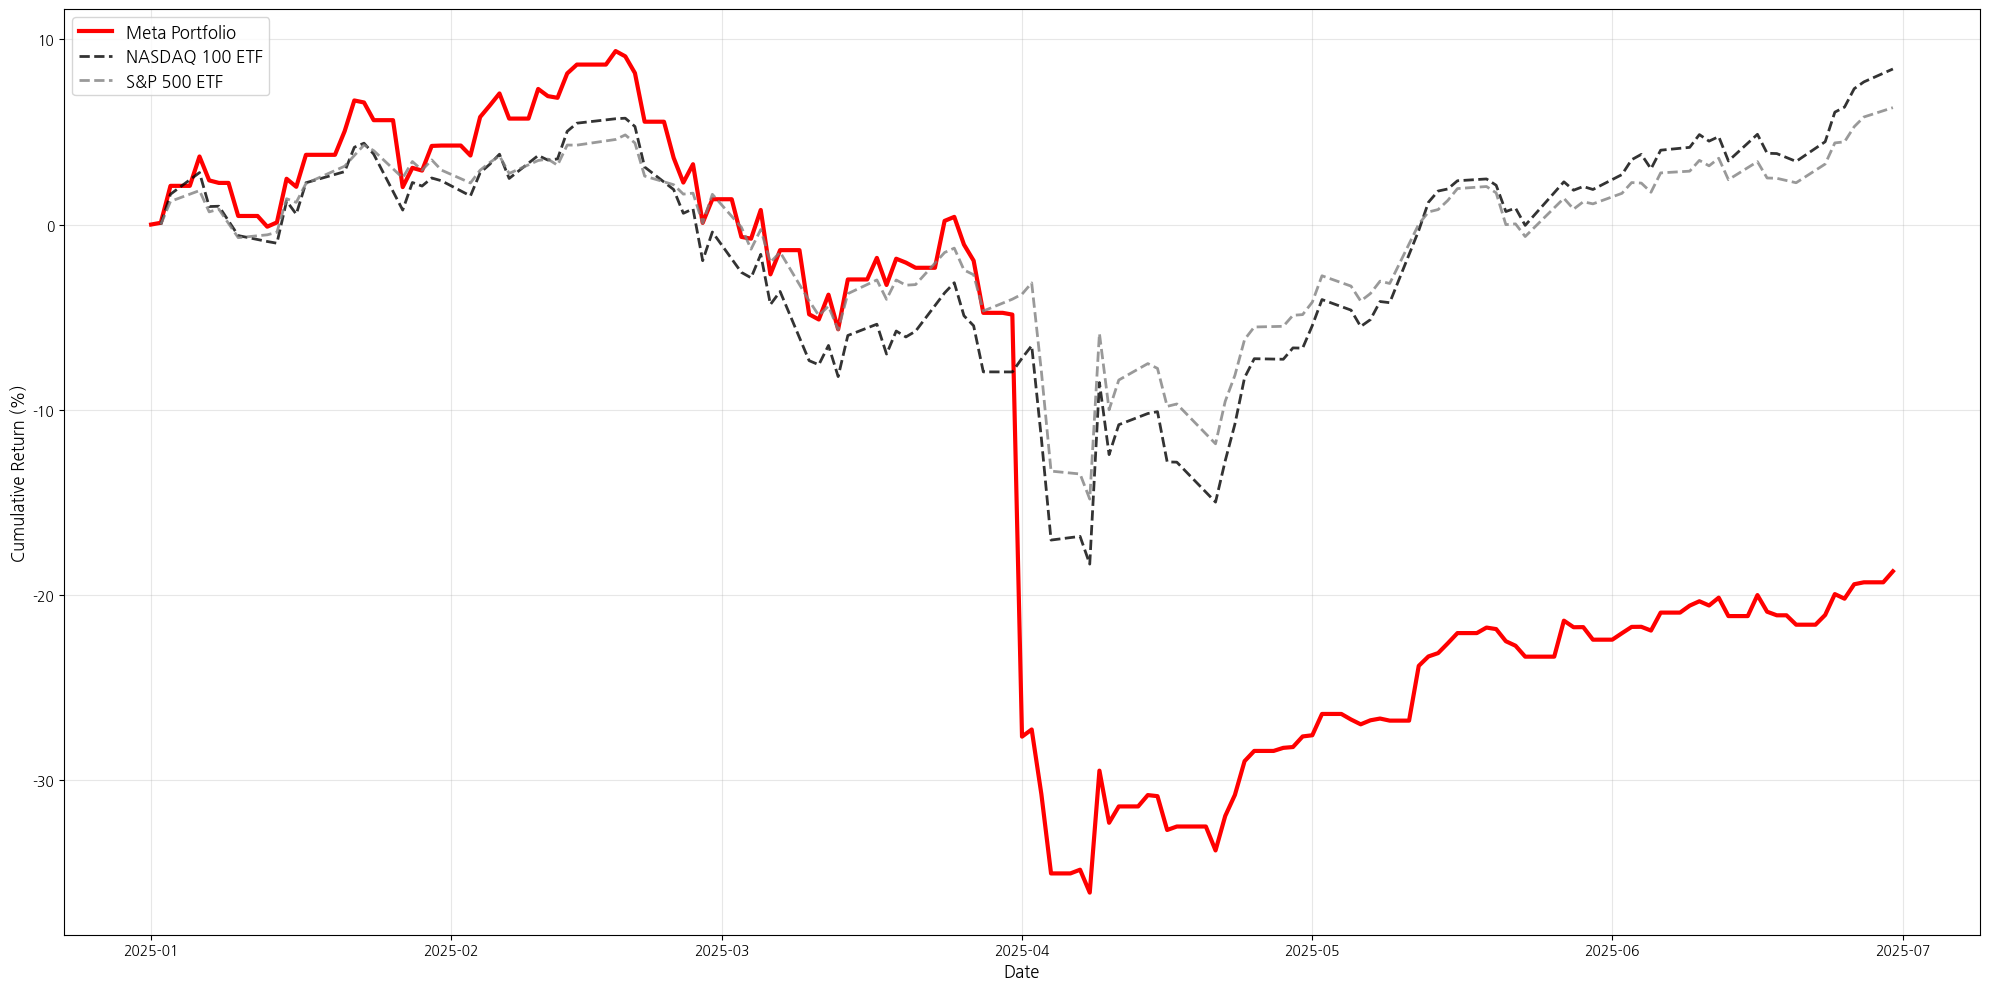

In [50]:
# 성과 차트 그리기
backtester.plot_meta_portfolio_performance()


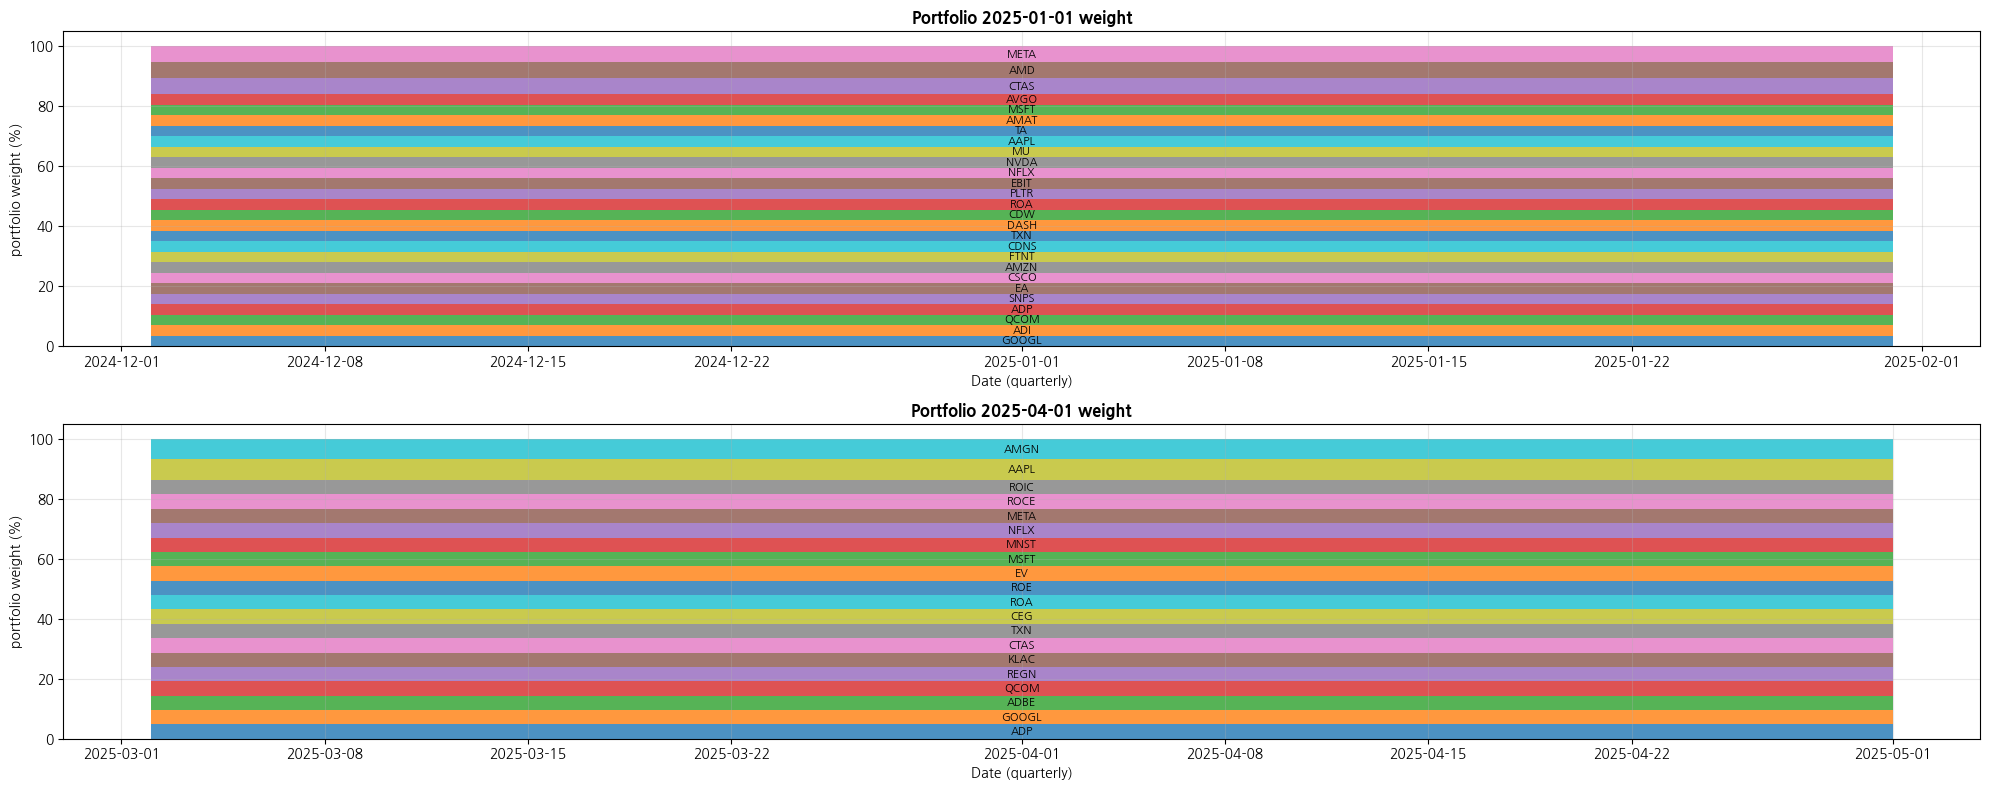

In [51]:
# 포트폴리오 구성 차트
backtester.plot_portfolio_weights()


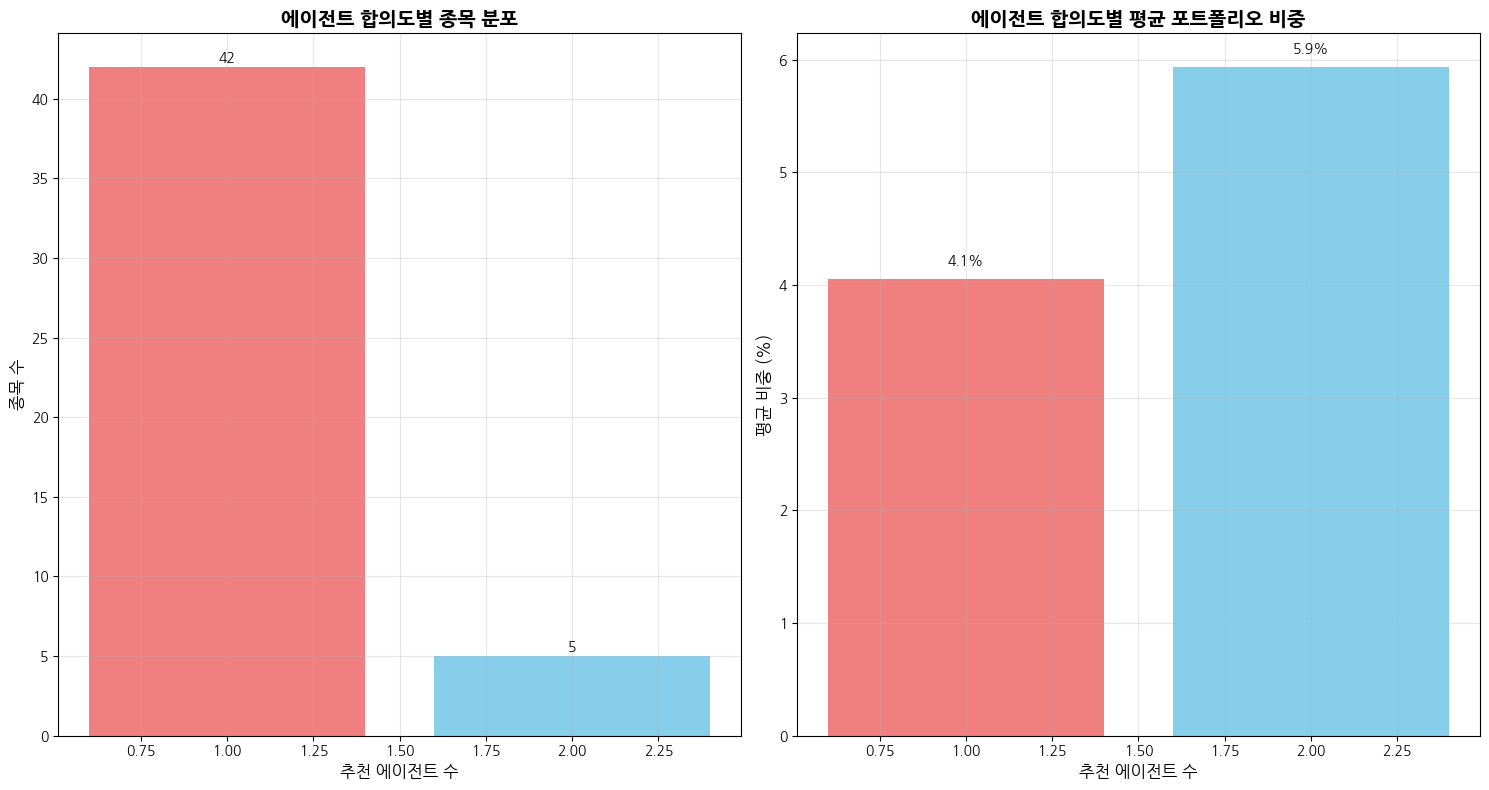

In [52]:
# 에이전트 합의도 분석 차트
backtester.plot_meta_portfolio_consensus()


In [53]:
# 결과 저장
backtester.save_meta_portfolio_results()


결과가 results/meta_portfolio_backtest_results.xlsx에 저장되었습니다.
